# Electron Photon tagging

This is a first test to implement a QAE. 
The task is to identify Electrons and Photons from em-calorimeter images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp


import warnings
warnings.filterwarnings('ignore')

2022-06-30 23:08:12.519537: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-30 23:08:12.519562: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-30 23:08:14.188732: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-30 23:08:14.188759: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-30 23:08:14.188777: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-06-30 23:08:14.189033: I tensorflow/core/platform/cpu_fe

In [2]:
data = np.load('../../data/electron-photon.npz', allow_pickle=True)
x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']

In [3]:
DOWNSCALE = 3
DATA_DIMENSION = DOWNSCALE*DOWNSCALE
LATENT_BITS = 2

x_train, x_test = dp.PCA_reduce(x_train, DATA_DIMENSION, val_data=x_test)

In [4]:
x_train_electrons = x_train[y_train==1]
x_train = x_train[y_train==0]

x_test_electrons = x_test[y_test==1]
x_test = x_test[y_test==0]

In [5]:
x_train_circuit = [dp.input_states_SQAE(x,DATA_DIMENSION,LATENT_BITS) for x in x_train]
x_test_circuit = [dp.input_states_SQAE(x,DATA_DIMENSION,LATENT_BITS) for x in x_test]

x_train_circuit_electrons = [dp.input_states_SQAE(x,DATA_DIMENSION,LATENT_BITS) for x in x_train_electrons]
x_test_circuit_electrons = [dp.input_states_SQAE(x,DATA_DIMENSION,LATENT_BITS) for x in x_test_electrons]

In [6]:
x_train_tf = tfq.convert_to_tensor(x_train_circuit)
x_test_tf = tfq.convert_to_tensor(x_test_circuit)

x_train_tf_electrons = tfq.convert_to_tensor(x_train_circuit_electrons)
x_test_tf_electrons = tfq.convert_to_tensor(x_test_circuit_electrons)

In [7]:
from hep_VQAE import QAE as qae

model = qae.SQAE_model(9,LATENT_BITS,9)

In [8]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.01))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


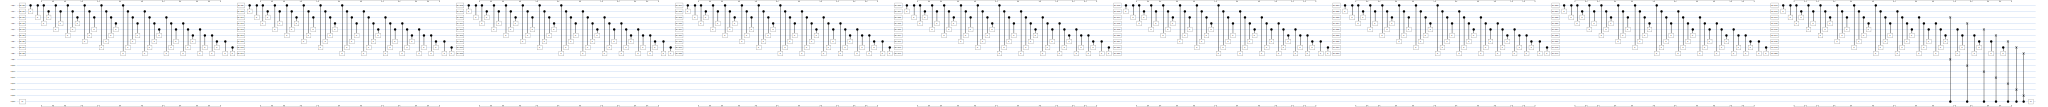

In [9]:
SVGCircuit(model.model_circuit)

In [10]:
y_train_ones = np.ones(shape=len(x_train_tf))
y_test_ones = np.ones(shape=len(x_test_tf))

y_train_ones_electrons = np.ones(shape=len(x_train_tf_electrons))
y_test_ones_electrons = np.ones(shape=len(x_test_tf_electrons))

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
history = model.fit(x_train_tf, y_train_ones, epochs=400, batch_size=16, validation_data=(x_test_tf, y_test_ones), callbacks=[es])

Epoch 1/400
3/3 [==============================] - 9s 3s/step - loss: 0.9900 - val_loss: 0.9838
Epoch 2/400
3/3 [==============================] - 8s 3s/step - loss: 0.9809 - val_loss: 0.9732
Epoch 3/400
3/3 [==============================] - 8s 3s/step - loss: 0.9692 - val_loss: 0.9603
Epoch 4/400
3/3 [==============================] - 8s 3s/step - loss: 0.9554 - val_loss: 0.9458
Epoch 5/400
3/3 [==============================] - 8s 3s/step - loss: 0.9399 - val_loss: 0.9304
Epoch 6/400
3/3 [==============================] - 8s 3s/step - loss: 0.9235 - val_loss: 0.9142
Epoch 7/400
3/3 [==============================] - 8s 3s/step - loss: 0.9066 - val_loss: 0.8974
Epoch 8/400
3/3 [==============================] - 8s 3s/step - loss: 0.8885 - val_loss: 0.8801
Epoch 9/400
3/3 [==============================] - 8s 3s/step - loss: 0.8707 - val_loss: 0.8624
Epoch 10/400
3/3 [==============================] - 8s 3s/step - loss: 0.8517 - val_loss: 0.8441
Epoch 11/400
3/3 [=====================

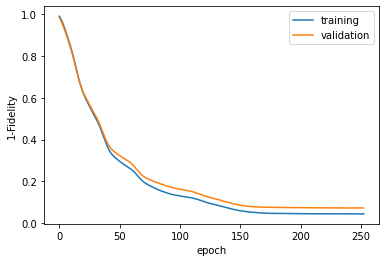

In [15]:
plt.plot(history.history['loss'], label="training")
plt.plot(history.history['val_loss'], label="validation")
#plt.yscale('log')
plt.xlabel("epoch")
plt.ylabel("1-Fidelity")
plt.legend()

0.7946826
0.8527957


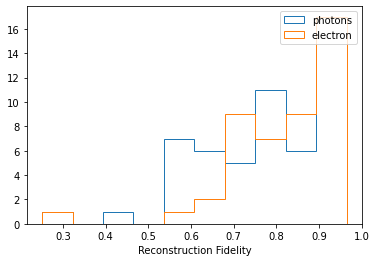

In [16]:
pred_photon = model.predict(x_test_tf)
print(np.median(pred_photon))
pred_electron = model.predict(x_test_tf_electrons)
print(np.median(pred_electron))
bins = np.histogram(np.hstack((pred_photon.reshape((pred_photon.shape[0],)), pred_electron.reshape((pred_electron.shape[0],)))), bins=10)[1]
plt.hist(pred_photon, histtype='step', label="photons",bins=bins)
plt.hist(pred_electron, histtype='step', label="electron",bins=bins)
plt.xlabel("Reconstruction Fidelity")
plt.legend()

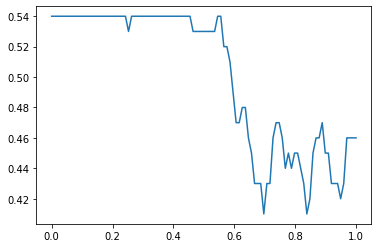

In [17]:
def acc_for_threshold(T):
    # sixes that are predicted six
    num_six_right = np.sum(pred_photon > T)
    # threes that are predicted three
    num_three_right = np.sum(pred_electron < T)
    acc = (num_six_right + num_three_right)/(len(pred_photon) + len(pred_electron))
    return acc

Ts = np.linspace(0,1,100)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
plt.plot(Ts, accs)  